In [1]:
import numpy as np
import torch as ch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from robustness.tools.vis_tools import show_image_column, show_image_row
from robustness.tools.label_maps import CLASS_DICT

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
RES_FILE = '/data/theory/robustopt/shibani/synthfar/Results/imagenet_backgrounds/v3_rl/random_per_class.csv'

In [3]:
df = pd.read_csv(RES_FILE)

In [4]:
df

,Unnamed: 0,labs,preds,mode,offset,num
0,0,0,0,random_per_class,[24 38 20 31 10 7 19 19 9 38],30
1,1,0,2,random_per_class,[24 38 20 31 10 7 19 19 9 38],20
2,2,0,3,random_per_class,[24 38 20 31 10 7 19 19 9 38],7
3,3,0,4,random_per_class,[24 38 20 31 10 7 19 19 9 38],8
4,4,0,5,random_per_class,[24 38 20 31 10 7 19 19 9 38],2
...,...,...,...,...,...,...
145791,93,9,5,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],8
145792,94,9,6,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],6
145793,95,9,7,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],3
145794,96,9,8,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],6


In [5]:
all_keys = ['mode', 'offset']

df['sameclass'] = (df['preds'] == df['labs'])

## Over all backgrounds

In [6]:
acc = 100 * np.sum(df['num'][df['sameclass']]) / np.sum(df['num'])
print(f"Mean accuracy over all background configs: {acc: .2f}")

Mean accuracy over all background configs:  7.01


In [7]:
conf_df = df.groupby(['labs', 'preds']).agg({'num': 'sum'}).reset_index()
CM = np.zeros((10, 10))
for l, p, n in zip(conf_df['labs'].values, conf_df['preds'].values, conf_df['num'].values):
    CM[l, p] = n

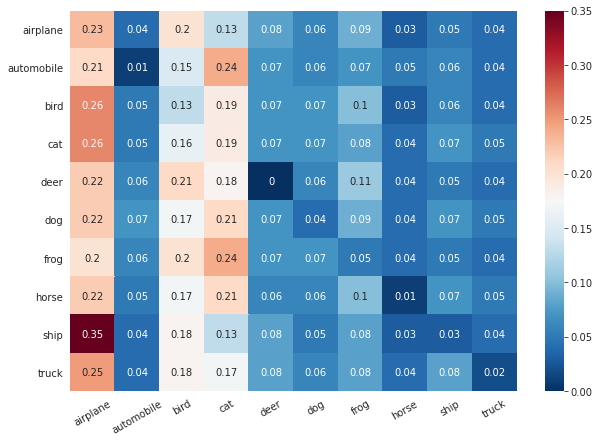

In [8]:
CM = CM / np.sum(CM, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(np.around(CM, decimals=2), cmap='RdBu_r', ax=ax, annot=True)
ax.set_xticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=30)
ax.set_yticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=0)

plt.show()

## Over specific configs

In [9]:
acc_df = df.groupby(all_keys + ['sameclass']).agg({'num': 'sum'}).reset_index()
acc_df = acc_df.pivot(index=all_keys, columns='sameclass', values='num').reset_index()
acc_df['acc'] = acc_df[True] / (acc_df[True] + acc_df[False])
del acc_df[True], acc_df[False]

In [10]:
acc_df

sameclass,mode,offset,acc
0,random_per_class,[ 0 1 47 22 8 49 4 47 20 49],0.042010
1,random_per_class,[ 0 2 46 34 18 13 47 39 42 6],0.055189
2,random_per_class,[ 0 4 3 0 6 21 45 41 5 13],0.047776
3,random_per_class,[ 0 4 27 26 39 18 44 9 16 17],0.037068
4,random_per_class,[ 0 6 19 12 13 6 19 45 4 45],0.032949
...,...,...,...
1495,random_per_class,[49 37 42 21 19 15 33 25 47 11],0.074135
1496,random_per_class,[49 42 45 46 34 49 44 35 6 48],0.066722
1497,random_per_class,[49 44 23 4 45 6 44 23 43 33],0.059308
1498,random_per_class,[49 49 35 41 39 40 17 28 45 49],0.084020


In [11]:
print(f"Min/max accuracy over single background configs: ",
     f" {100 * np.min(acc_df['acc']): .2f}, {100 * np.max(acc_df['acc']): .2f}")

Min/max accuracy over single background configs:    2.72,  12.69


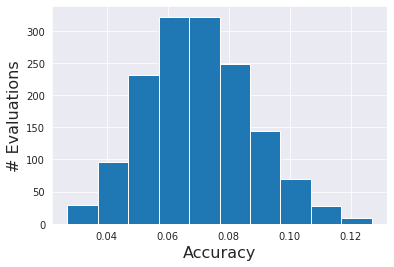

In [12]:
plt.hist(acc_df['acc'])
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('# Evaluations', fontsize=16)
plt.show()

## Best over configs

In [13]:
df

,Unnamed: 0,labs,preds,mode,offset,num,sameclass
0,0,0,0,random_per_class,[24 38 20 31 10 7 19 19 9 38],30,True
1,1,0,2,random_per_class,[24 38 20 31 10 7 19 19 9 38],20,False
2,2,0,3,random_per_class,[24 38 20 31 10 7 19 19 9 38],7,False
3,3,0,4,random_per_class,[24 38 20 31 10 7 19 19 9 38],8,False
4,4,0,5,random_per_class,[24 38 20 31 10 7 19 19 9 38],2,False
...,...,...,...,...,...,...,...
145791,93,9,5,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],8,False
145792,94,9,6,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],6,False
145793,95,9,7,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],3,False
145794,96,9,8,random_per_class,[ 1 46 38 45 20 12 15 18 16 17],6,False


In [14]:
perclass_acc_df = df.groupby(all_keys + ['sameclass', 'labs']).agg({'num': 'sum'}).reset_index()
perclass_acc_df = perclass_acc_df.pivot(index=all_keys + ['labs'], columns='sameclass', values='num').reset_index()
perclass_acc_df['acc'] = perclass_acc_df[True] / (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df['count'] = (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df

sameclass,mode,offset,labs,False,True,acc,count
0,random_per_class,[ 0 1 47 22 8 49 4 47 20 49],0,145.0,5.0,0.033333,150.0
1,random_per_class,[ 0 1 47 22 8 49 4 47 20 49],1,115.0,NaN,NaN,NaN
2,random_per_class,[ 0 1 47 22 8 49 4 47 20 49],2,89.0,16.0,0.152381,105.0
3,random_per_class,[ 0 1 47 22 8 49 4 47 20 49],3,101.0,20.0,0.165289,121.0
4,random_per_class,[ 0 1 47 22 8 49 4 47 20 49],4,125.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
14995,random_per_class,[49 49 44 23 43 46 38 2 44 30],5,116.0,8.0,0.064516,124.0
14996,random_per_class,[49 49 44 23 43 46 38 2 44 30],6,86.0,25.0,0.225225,111.0
14997,random_per_class,[49 49 44 23 43 46 38 2 44 30],7,111.0,NaN,NaN,NaN
14998,random_per_class,[49 49 44 23 43 46 38 2 44 30],8,119.0,1.0,0.008333,120.0


In [15]:
avg_df = perclass_acc_df.groupby('labs').agg({'acc': 'mean', 'count': 'sum'}).reset_index()

avg_df

,labs,acc,count
0,0,0.230009,173003.0
1,1,0.012678,86350.0
2,2,0.130278,182872.0
3,3,0.187737,190788.0
4,4,0.010187,42859.0
5,5,0.038458,175021.0
6,6,0.058499,162504.0
7,7,0.013466,92603.0
8,8,0.035442,163350.0
9,9,0.023494,144329.0


## Per class

In [16]:
perclass_acc_df = perclass_acc_df.loc[perclass_acc_df.groupby('labs')['acc'].idxmax()]

In [17]:
perclass_acc_df

sameclass,mode,offset,labs,False,True,acc,count
5300,random_per_class,[17 5 45 12 25 20 19 1 33 38],0,64.0,49.0,0.433628,113.0
7791,random_per_class,[25 19 47 44 9 8 12 39 9 30],1,118.0,9.0,0.070866,127.0
4232,random_per_class,[14 3 48 20 32 30 43 11 19 32],2,76.0,43.0,0.361345,119.0
123,random_per_class,[ 0 18 27 41 40 36 33 39 42 13],3,69.0,63.0,0.477273,132.0
13604,random_per_class,[44 48 35 38 42 6 13 34 34 44],4,83.0,5.0,0.056818,88.0
11405,random_per_class,[37 18 31 2 6 11 48 33 4 8],5,104.0,16.0,0.133333,120.0
1776,random_per_class,[ 6 18 48 9 33 12 26 17 29 43],6,85.0,45.0,0.346154,130.0
5547,random_per_class,[18 0 14 49 48 41 8 9 17 10],7,95.0,7.0,0.068627,102.0
10838,random_per_class,[35 24 34 49 17 40 1 32 38 45],8,114.0,22.0,0.161765,136.0
2059,random_per_class,[ 7 9 39 25 4 48 16 20 47 27],9,78.0,20.0,0.204082,98.0


In [18]:
sum(perclass_acc_df['acc'] * perclass_acc_df['count']) / sum(perclass_acc_df['count'])

0.23948497854077253

In [19]:
CM_best = np.zeros((10, 10))

for l, o in zip(perclass_acc_df['labs'], perclass_acc_df['offset']):
    curr = df[np.logical_and(df['labs'] == l, df['offset'] == o)]
    for p, n in zip(curr['preds'], curr['num']):
        CM_best[l, p] = n
CM_best = CM_best / np.sum(CM_best, axis=1)

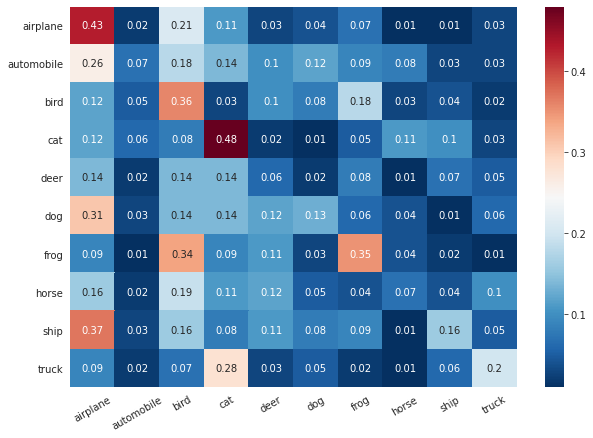

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(np.around(CM_best, decimals=2), cmap='RdBu_r', ax=ax, annot=True)
ax.set_xticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=30)
ax.set_yticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=0)

plt.show()